In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap

df = pd.read_csv("../data/processed/df_clean.csv")
X = df.drop(columns=['Churn','customerID'])
y = df['Churn']

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# F1 scorer
f1_scorer = make_scorer(f1_score)


In [2]:
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}

grid_lr = GridSearchCV(LogisticRegression(max_iter=5000), param_grid_lr, cv=3, scoring=f1_scorer)
grid_lr.fit(X_train, y_train)
print("Best LR params:", grid_lr.best_params_)
print("Best LR F1:", grid_lr.best_score_)


Best LR params: {'C': 1}
Best LR F1: 0.5795517253872278


In [3]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring=f1_scorer)
grid_rf.fit(X_train, y_train)
print("Best RF params:", grid_rf.best_params_)
print("Best RF F1:", grid_rf.best_score_)


Best RF params: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}
Best RF F1: 0.5596011564268467


In [4]:
lgb_model = lgb.LGBMClassifier(objective='binary', random_state=42)

param_grid_lgb = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500]
}

grid_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=3, scoring=f1_scorer)
grid_lgb.fit(X_train, y_train)
print("Best LGB params:", grid_lgb.best_params_)
print("Best LGB F1:", grid_lgb.best_score_)


[LightGBM] [Info] Number of positive: 998, number of negative: 2758
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1522
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265708 -> initscore=-1.016508
[LightGBM] [Info] Start training from score -1.016508
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1521
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 28
[LightGBM] [Info] [binary:

In [5]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, seed=42)

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'subsample': [0.7, 0.8, 1]
}

grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring=f1_scorer)
grid_xgb.fit(X_train, y_train)
print("Best XGB params:", grid_xgb.best_params_)
print("Best XGB F1:", grid_xgb.best_score_)


c:\Users\6the6\Desktop\customer-churn-ml\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:09:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\6the6\Desktop\customer-churn-ml\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:09:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\6the6\Desktop\customer-churn-ml\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:09:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\6the6\Desktop\customer-churn-ml\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:09:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\

Best XGB params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best XGB F1: 0.5823277970366977


c:\Users\6the6\Desktop\customer-churn-ml\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:10:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [6]:
best_models = {
    'Logistic Regression': grid_lr.best_estimator_,
    'Random Forest': grid_rf.best_estimator_,
    'LightGBM': grid_lgb.best_estimator_,
    'XGBoost': grid_xgb.best_estimator_
}

for name, model in best_models.items():
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:,1]
    print(f"{name} F1-score:", f1_score(y_val, y_pred))
    print(f"{name} AUC:", roc_auc_score(y_val, y_proba))


Logistic Regression F1-score: 0.6191860465116279
Logistic Regression AUC: 0.8588689225418448
Random Forest F1-score: 0.6123076923076923
Random Forest AUC: 0.8554776051424844
LightGBM F1-score: 0.6048632218844985
LightGBM AUC: 0.8570962766673222
XGBoost F1-score: 0.6081694402420574
XGBoost AUC: 0.8625073752419598


c:\Users\6the6\Desktop\customer-churn-ml\venv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


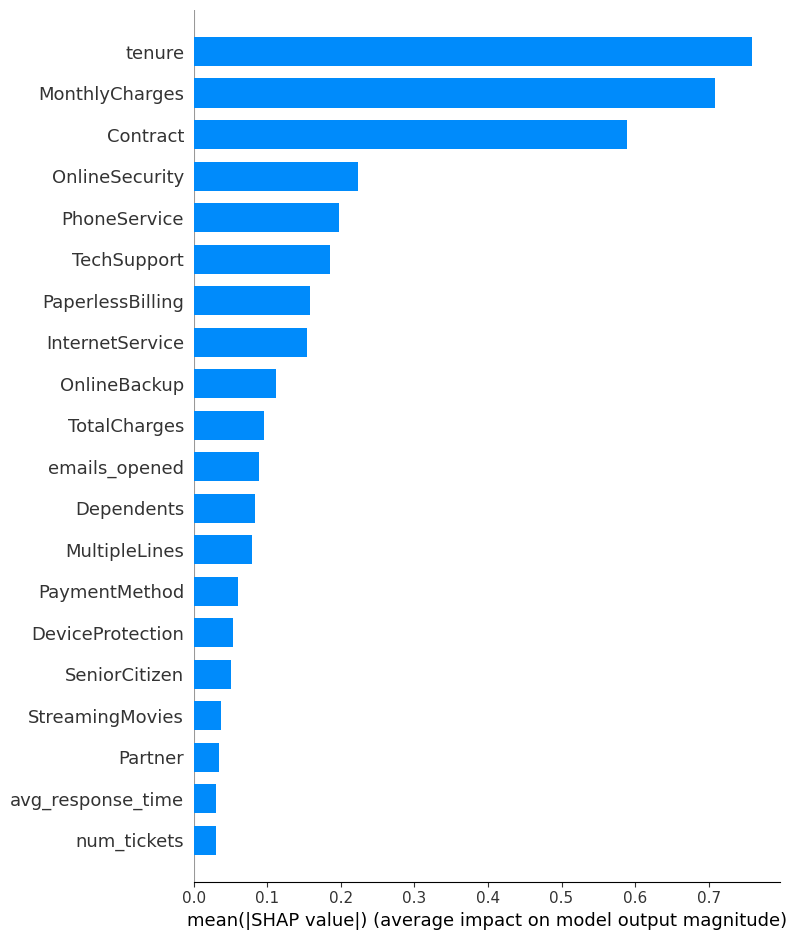

In [7]:
explainer = shap.LinearExplainer(grid_lr.best_estimator_, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar", show=False)

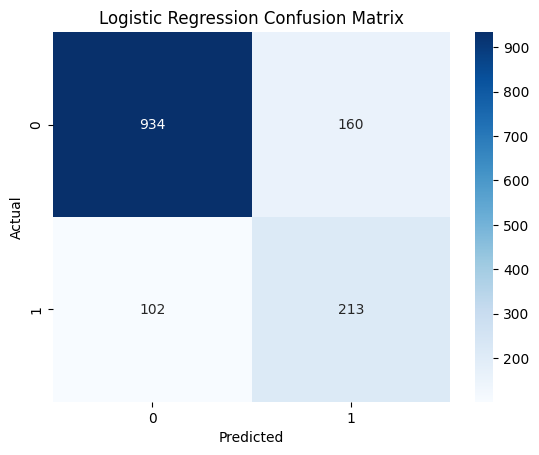

In [8]:
best_model_name = 'Logistic Regression'
cm = confusion_matrix(best_models[best_model_name].predict(X_val), y_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(f"{best_model_name} Confusion Matrix")
plt.show()
